In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("darkgrid")
pd.set_option("display.max_columns", 130)
pd.set_option("display.max_rows", 130)

##### Following topics to be covered
1. Downloading a real world dataset from a kaggle competition
2. Performing feature engineering and prepare the dataset for training
3. Training and interpreting a gradient boosting model using XGBoost
4. Training with KFold cross validation and ensembling results
5. Configuring the gradient boosting model and tuning hyperparameters

In [2]:
# !pip install opendatasets xgboost graphviz lightgbm 

In [3]:
store_df = pd.read_csv("rossmann-store-sales/store.csv")
train_df = pd.read_csv("rossmann-store-sales/train.csv", low_memory=False)
test_df = pd.read_csv("rossmann-store-sales/test.csv")
submission_df = pd.read_csv("rossmann-store-sales/sample_submission.csv")

In [4]:
store_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [5]:
train_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [6]:
test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0


In [7]:
store_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,1115.0,558.000000,322.017080,1.0,279.5,558.0,836.5,1115.0
CompetitionDistance,1112.0,5404.901079,7663.174720,20.0,717.5,2325.0,6882.5,75860.0
CompetitionOpenSinceMonth,761.0,7.224704,3.212348,1.0,4.0,8.0,10.0,12.0
CompetitionOpenSinceYear,761.0,2008.668857,6.195983,1900.0,2006.0,2010.0,2013.0,2015.0
Promo2,1115.0,0.512108,0.500078,0.0,0.0,1.0,1.0,1.0
Promo2SinceWeek,571.0,23.595447,14.141984,1.0,13.0,22.0,37.0,50.0
Promo2SinceYear,571.0,2011.763573,1.674935,2009.0,2011.0,2012.0,2013.0,2015.0


In [8]:
def convert_date(df):
    df["Date"] = pd.to_datetime(merged_df.Date)
    df["Year"] = pd.to_datetime(merged_df.Date).dt.year
    df["Month"] = pd.to_datetime(merged_df.Date).dt.month
    df["Day"] = pd.to_datetime(merged_df.Date).dt.day
    df["WeekOfYear"] = pd.to_datetime(merged_df.Date).dt.isocalendar().week
    

In [9]:
merged_df = train_df.merge(store_df, how="left", on="Store")

In [10]:
merged_test_df = test_df.merge(store_df, how="left", on="Store")

In [11]:
convert_date(merged_df)
convert_date(merged_test_df)

In [12]:
merged_df = merged_df[merged_df.Open == 1].copy()

In [13]:
def comp_months(df):
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    df["CompetitionOpen"] = df["CompetitionOpen"].map(lambda x:0 if x < 0 else x).fillna(0)

In [14]:
comp_months(merged_df)
comp_months(merged_test_df)

In [15]:
merged_df[["Date", "CompetitionDistance", "CompetitionOpenSinceYear", "CompetitionOpenSinceMonth", "Year", "Month", "CompetitionOpen"]]

,Date,CompetitionDistance,CompetitionOpenSinceYear,CompetitionOpenSinceMonth,Year,Month,CompetitionOpen
0,2015-07-31,1270.0,2008.0,9.0,2015,7,82.0
1,2015-07-31,570.0,2007.0,11.0,2015,7,92.0
2,2015-07-31,14130.0,2006.0,12.0,2015,7,103.0
3,2015-07-31,620.0,2009.0,9.0,2015,7,70.0
4,2015-07-31,29910.0,2015.0,4.0,2015,7,3.0
...,...,...,...,...,...,...,...
1016776,2013-01-01,150.0,2006.0,9.0,2013,1,76.0
1016827,2013-01-01,860.0,1999.0,10.0,2013,1,159.0
1016863,2013-01-01,840.0,NaN,NaN,2013,1,0.0
1017042,2013-01-01,1430.0,NaN,NaN,2013,1,0.0


In [16]:
def check_promo_month(row):
    monthToStr = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6:"Jun",
                 7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11:"Nov", 12: "Dec"}
    try:
        months =  (row["PromoInterval"] or '').split(",")
        if row["Promo2Open"] and monthToStr[row["Month"]] in months:
            return 1
        return 0
    except Exception:
        return 0
def promo_cols(df):
    df["Promo2Open"] = 12 * (df.Year - df.Promo2SinceYear) + (df.WeekOfYear - df.Promo2SinceWeek) / 4.345
    df["Promo2Open"] = df["Promo2Open"].map(lambda x: 0 if x < 0 else x).fillna(0) * df["Promo2"]
    df["isPromo2Month"] = df.apply(check_promo_month, axis =1)* df["Promo2"]

In [17]:
sample_df = merged_df.copy()

In [18]:
promo_cols(merged_df)

In [19]:
promo_cols(merged_test_df)

In [20]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen,Promo2Open,isPromo2Month
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31,82.0,0.000000,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,92.0,64.142693,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,103.0,51.912543,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31,70.0,0.000000,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31,3.0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,1,0,a,1,b,a,150.0,9.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1,76.0,0.000000,0
1016827,733,2,2013-01-01,10765,2377,1,0,a,1,b,b,860.0,10.0,1999.0,0,NaN,NaN,NaN,2013,1,1,1,159.0,0.000000,0
1016863,769,2,2013-01-01,5035,1248,1,0,a,1,b,b,840.0,NaN,NaN,1,48.0,2012.0,"Jan,Apr,Jul,Oct",2013,1,1,1,0.0,1.182969,1
1017042,948,2,2013-01-01,4491,1039,1,0,a,1,b,b,1430.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1,0.0,0.000000,0


In [21]:
merged_df.isna().sum()[merged_df.isna().sum() != 0]

CompetitionDistance            2186
CompetitionOpenSinceMonth    268619
CompetitionOpenSinceYear     268619
Promo2SinceWeek              423307
Promo2SinceYear              423307
PromoInterval                423307
dtype: int64

In [22]:
merged_test_df.isna().sum()[merged_test_df.isna().sum() != 0]

Open                            11
CompetitionDistance             96
CompetitionOpenSinceMonth    15216
CompetitionOpenSinceYear     15216
Promo2SinceWeek              17232
Promo2SinceYear              17232
PromoInterval                17232
dtype: int64

In [23]:
merged_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'isPromo2Month'],
      dtype='object')

In [24]:
input_cols = ["Store", "DayOfWeek", "Promo", "StateHoliday", "SchoolHoliday", "StoreType",
             "Assortment", "CompetitionDistance", "CompetitionOpen", "Day", "Month", "Year", 
              "WeekOfYear", "Promo2", "Promo2Open", "isPromo2Month"]
target_cols = "Sales"              

In [25]:
inputs = merged_df[input_cols].copy()
targets = merged_df[target_cols].copy()

In [26]:
targets

0           5263
1           6064
2           8314
3          13995
4           4822
           ...  
1016776     3375
1016827    10765
1016863     5035
1017042     4491
1017190     5961
Name: Sales, Length: 844392, dtype: int64

In [27]:
test_inputs = merged_test_df[input_cols].copy()
merged_test_df.columns.tolist()

['Id',
 'Store',
 'DayOfWeek',
 'Date',
 'Open',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'PromoInterval',
 'Year',
 'Month',
 'Day',
 'WeekOfYear',
 'CompetitionOpen',
 'Promo2Open',
 'isPromo2Month']

In [28]:
test_inputs.columns.tolist()

['Store',
 'DayOfWeek',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'CompetitionOpen',
 'Day',
 'Month',
 'Year',
 'WeekOfYear',
 'Promo2',
 'Promo2Open',
 'isPromo2Month']

In [29]:
numerical_cols = inputs.select_dtypes(np.number).columns.tolist()
categorical_cols = inputs.select_dtypes("object").columns.tolist()

In [30]:
numerical_cols.pop(1)

'DayOfWeek'

In [31]:
categorical_cols.append("DayOfWeek")

In [32]:
categorical_cols

['StateHoliday', 'StoreType', 'Assortment', 'DayOfWeek']

In [33]:
inputs[numerical_cols].isna().sum()

Store                     0
Promo                     0
SchoolHoliday             0
CompetitionDistance    2186
CompetitionOpen           0
Day                       0
Month                     0
Year                      0
WeekOfYear                0
Promo2                    0
Promo2Open                0
isPromo2Month             0
dtype: int64

In [34]:
test_inputs[numerical_cols].isna().sum()

Store                   0
Promo                   0
SchoolHoliday           0
CompetitionDistance    96
CompetitionOpen         0
Day                     0
Month                   0
Year                    0
WeekOfYear              0
Promo2                  0
Promo2Open              0
isPromo2Month           0
dtype: int64

In [35]:
inputs.CompetitionDistance.describe().T

count    842206.000000
mean       5457.979627
std        7809.437311
min          20.000000
25%         710.000000
50%        2320.000000
75%        6890.000000
max       75860.000000
Name: CompetitionDistance, dtype: float64

In [36]:
max_distance = inputs.CompetitionDistance.max()
max_distance

75860.0

In [37]:
inputs["CompetitionDistance"].fillna(max_distance*2, inplace=True)

In [38]:
test_inputs["CompetitionDistance"].fillna(max_distance*2, inplace=True)

In [39]:
inputs[categorical_cols].isna().sum()

StateHoliday    0
StoreType       0
Assortment      0
DayOfWeek       0
dtype: int64

In [40]:
test_inputs[categorical_cols].isna().sum()

StateHoliday    0
StoreType       0
Assortment      0
DayOfWeek       0
dtype: int64

In [41]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [42]:
scaler = MinMaxScaler().fit(inputs[numerical_cols])

In [43]:
inputs[numerical_cols] = scaler.transform(inputs[numerical_cols])

In [44]:
test_inputs[numerical_cols] = scaler.transform(test_inputs[numerical_cols])

In [45]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoder.fit(inputs[categorical_cols])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [46]:
encoded_cols = encoder.get_feature_names_out().tolist()
encoded_cols

['StateHoliday_0',
 'StateHoliday_a',
 'StateHoliday_b',
 'StateHoliday_c',
 'StoreType_a',
 'StoreType_b',
 'StoreType_c',
 'StoreType_d',
 'Assortment_a',
 'Assortment_b',
 'Assortment_c',
 'DayOfWeek_1',
 'DayOfWeek_2',
 'DayOfWeek_3',
 'DayOfWeek_4',
 'DayOfWeek_5',
 'DayOfWeek_6',
 'DayOfWeek_7']

In [47]:
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])

In [48]:
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

In [49]:
X_train = inputs[numerical_cols + encoded_cols]
X_test = test_inputs[numerical_cols + encoded_cols]

#### We haven't created a validation set yet because we will use K-Fold cross validation

# Gradient Boosting
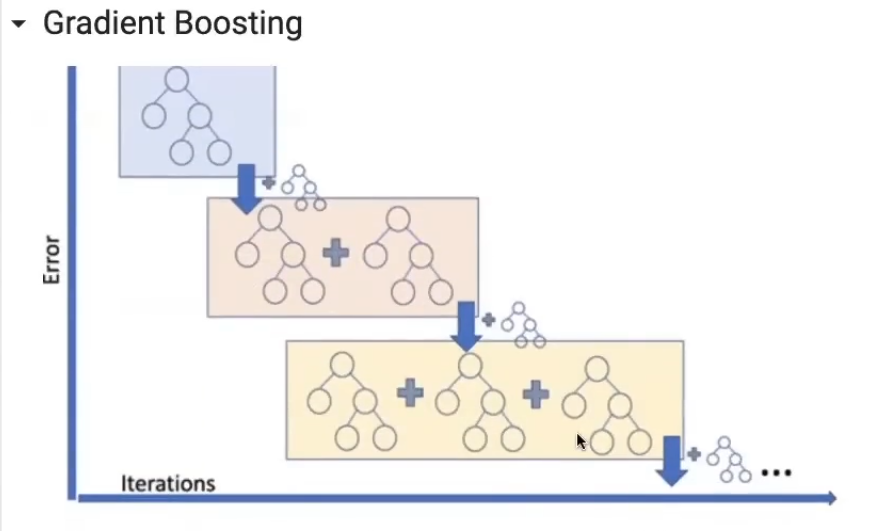
1. The average value of the target columns and uses as an initial prediction for every input
2. The residuals (difference) of the predictions with the targets are computed.
3. A decision tree of limited depth is trained to predict just the residuals for each input
4. Predictions from the decision tree are scaled using a parameter called the learning rate (this prevents overfitting)
5. Scaled predictions from the tree are added to the previous predictions to obtain the new and improved predictions. 
6. Steps 2 t0 5 are repeated to create new decision trees, each of which is trained to predict

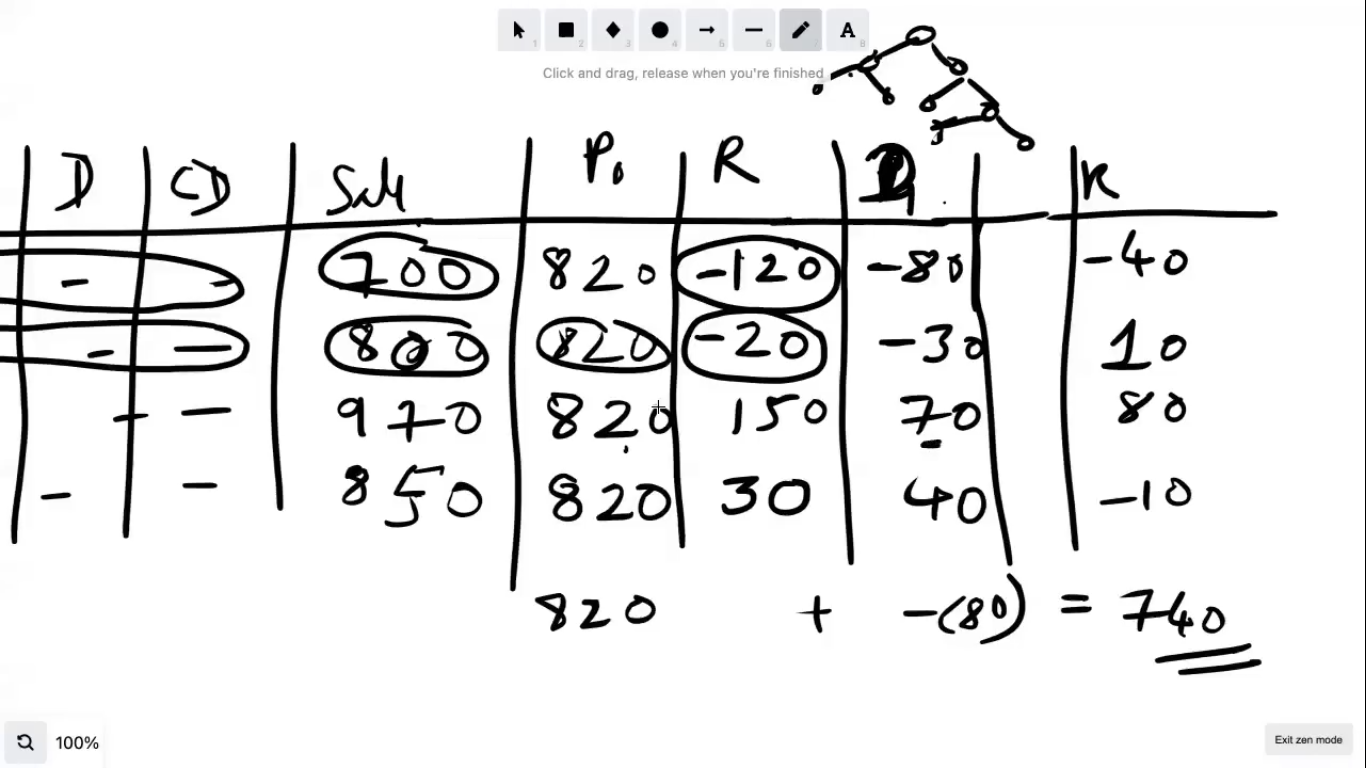


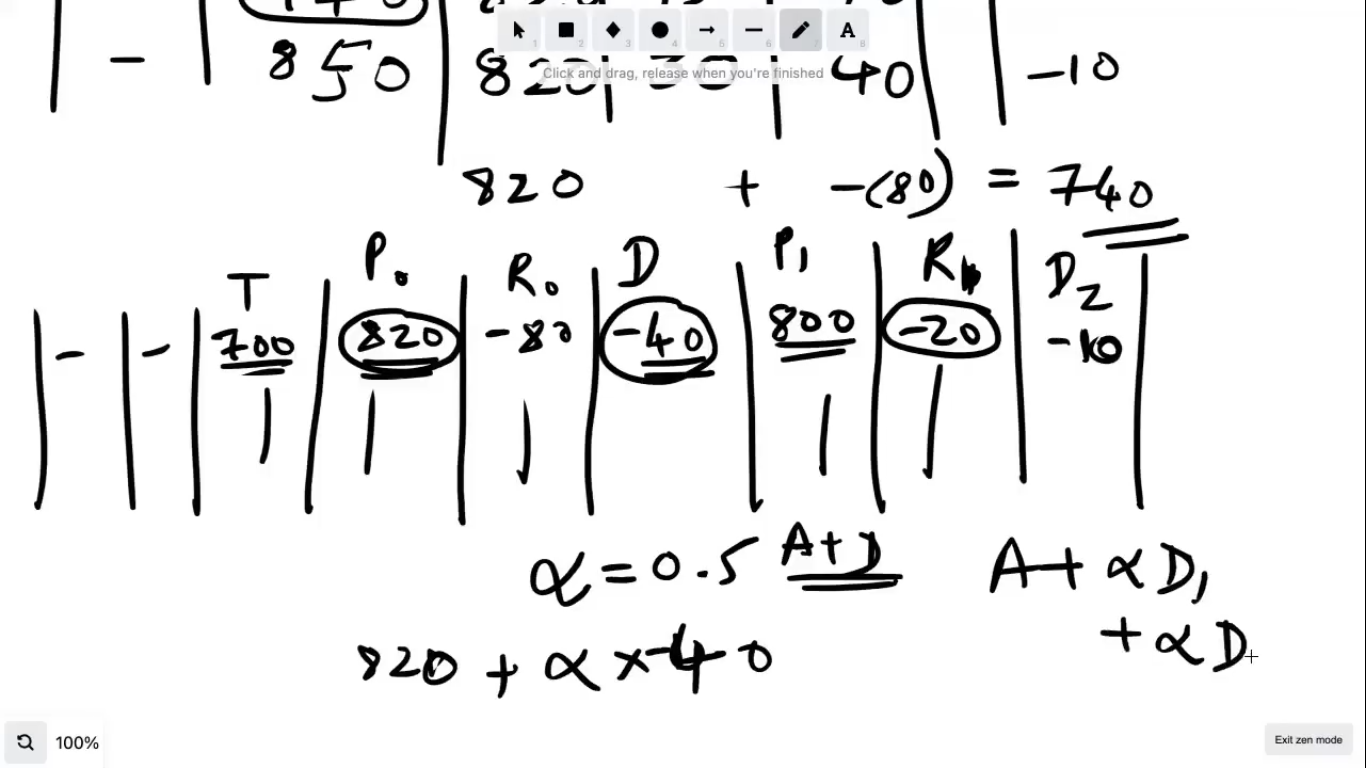

$ (Average + alpha(0.5) + d) + (alpha + d) +..... $

### Difference between Gradient Boosting and Random Forest Classifier

### Gradient Boosting:

1. Builds multiple decision trees each correcting the errors of the past (i.e. sequential)
2. Combines the output of individual trees to make a final prediction
3. More prone to overfitting than Random Forest
4. Slower and more computationally expensive for large datasets

### Random Forest classifier:
1. Provided feature importances scores
2. Builds multiple decision trees and combine their output to make predictions
3. Trees are independent and can be trained in parallel
4. Handles missing values and outliers well

In [50]:
from xgboost import XGBRegressor

In [51]:
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4)

In [52]:
model.fit(X_train, targets)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [53]:
preds = model.predict(X_train)

In [54]:
preds

array([ 8131.5044,  7312.157 ,  8846.703 , ...,  7076.3633,  7685.781 ,
       10194.288 ], dtype=float32)

In [55]:
from sklearn.metrics import mean_squared_error as mse

In [56]:
mse(targets, preds, squared=False)

2366.7912727906537

In [57]:
import sklearn
sklearn.metrics.mean_squared_log_error(targets, preds)

0.11927650574323155

In [58]:
merged_df.Sales.min(), merged_df.Sales.max()

(0, 41551)

In [59]:
preds.min(), preds.max()

(3047.0728, 22055.656)

(array([5.03060e+04, 4.00159e+05, 2.76528e+05, 9.40690e+04, 1.62870e+04,
        4.46900e+03, 2.11500e+03, 4.25000e+02, 3.00000e+01, 4.00000e+00]),
 array([ 3047.07275391,  4947.93115234,  6848.78955078,  8749.64746094,
        10650.50585938, 12551.36425781, 14452.22265625, 16353.08105469,
        18253.93945312, 20154.79882812, 22055.65625   ]),
 <BarContainer object of 10 artists>)

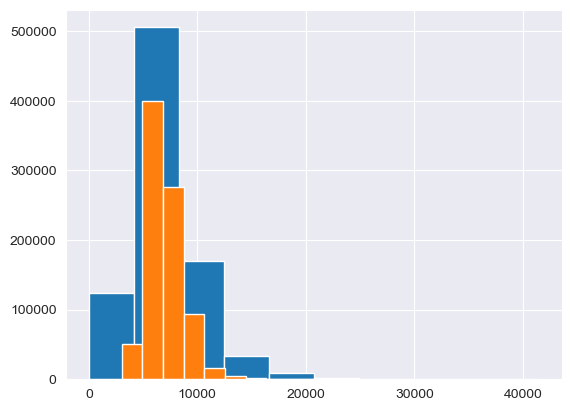

In [60]:
plt.hist(merged_df.Sales)
plt.hist(preds)

In [61]:
from xgboost import plot_tree
plt.rcParams['figure.figsize'] = (30, 60)

<Axes: >

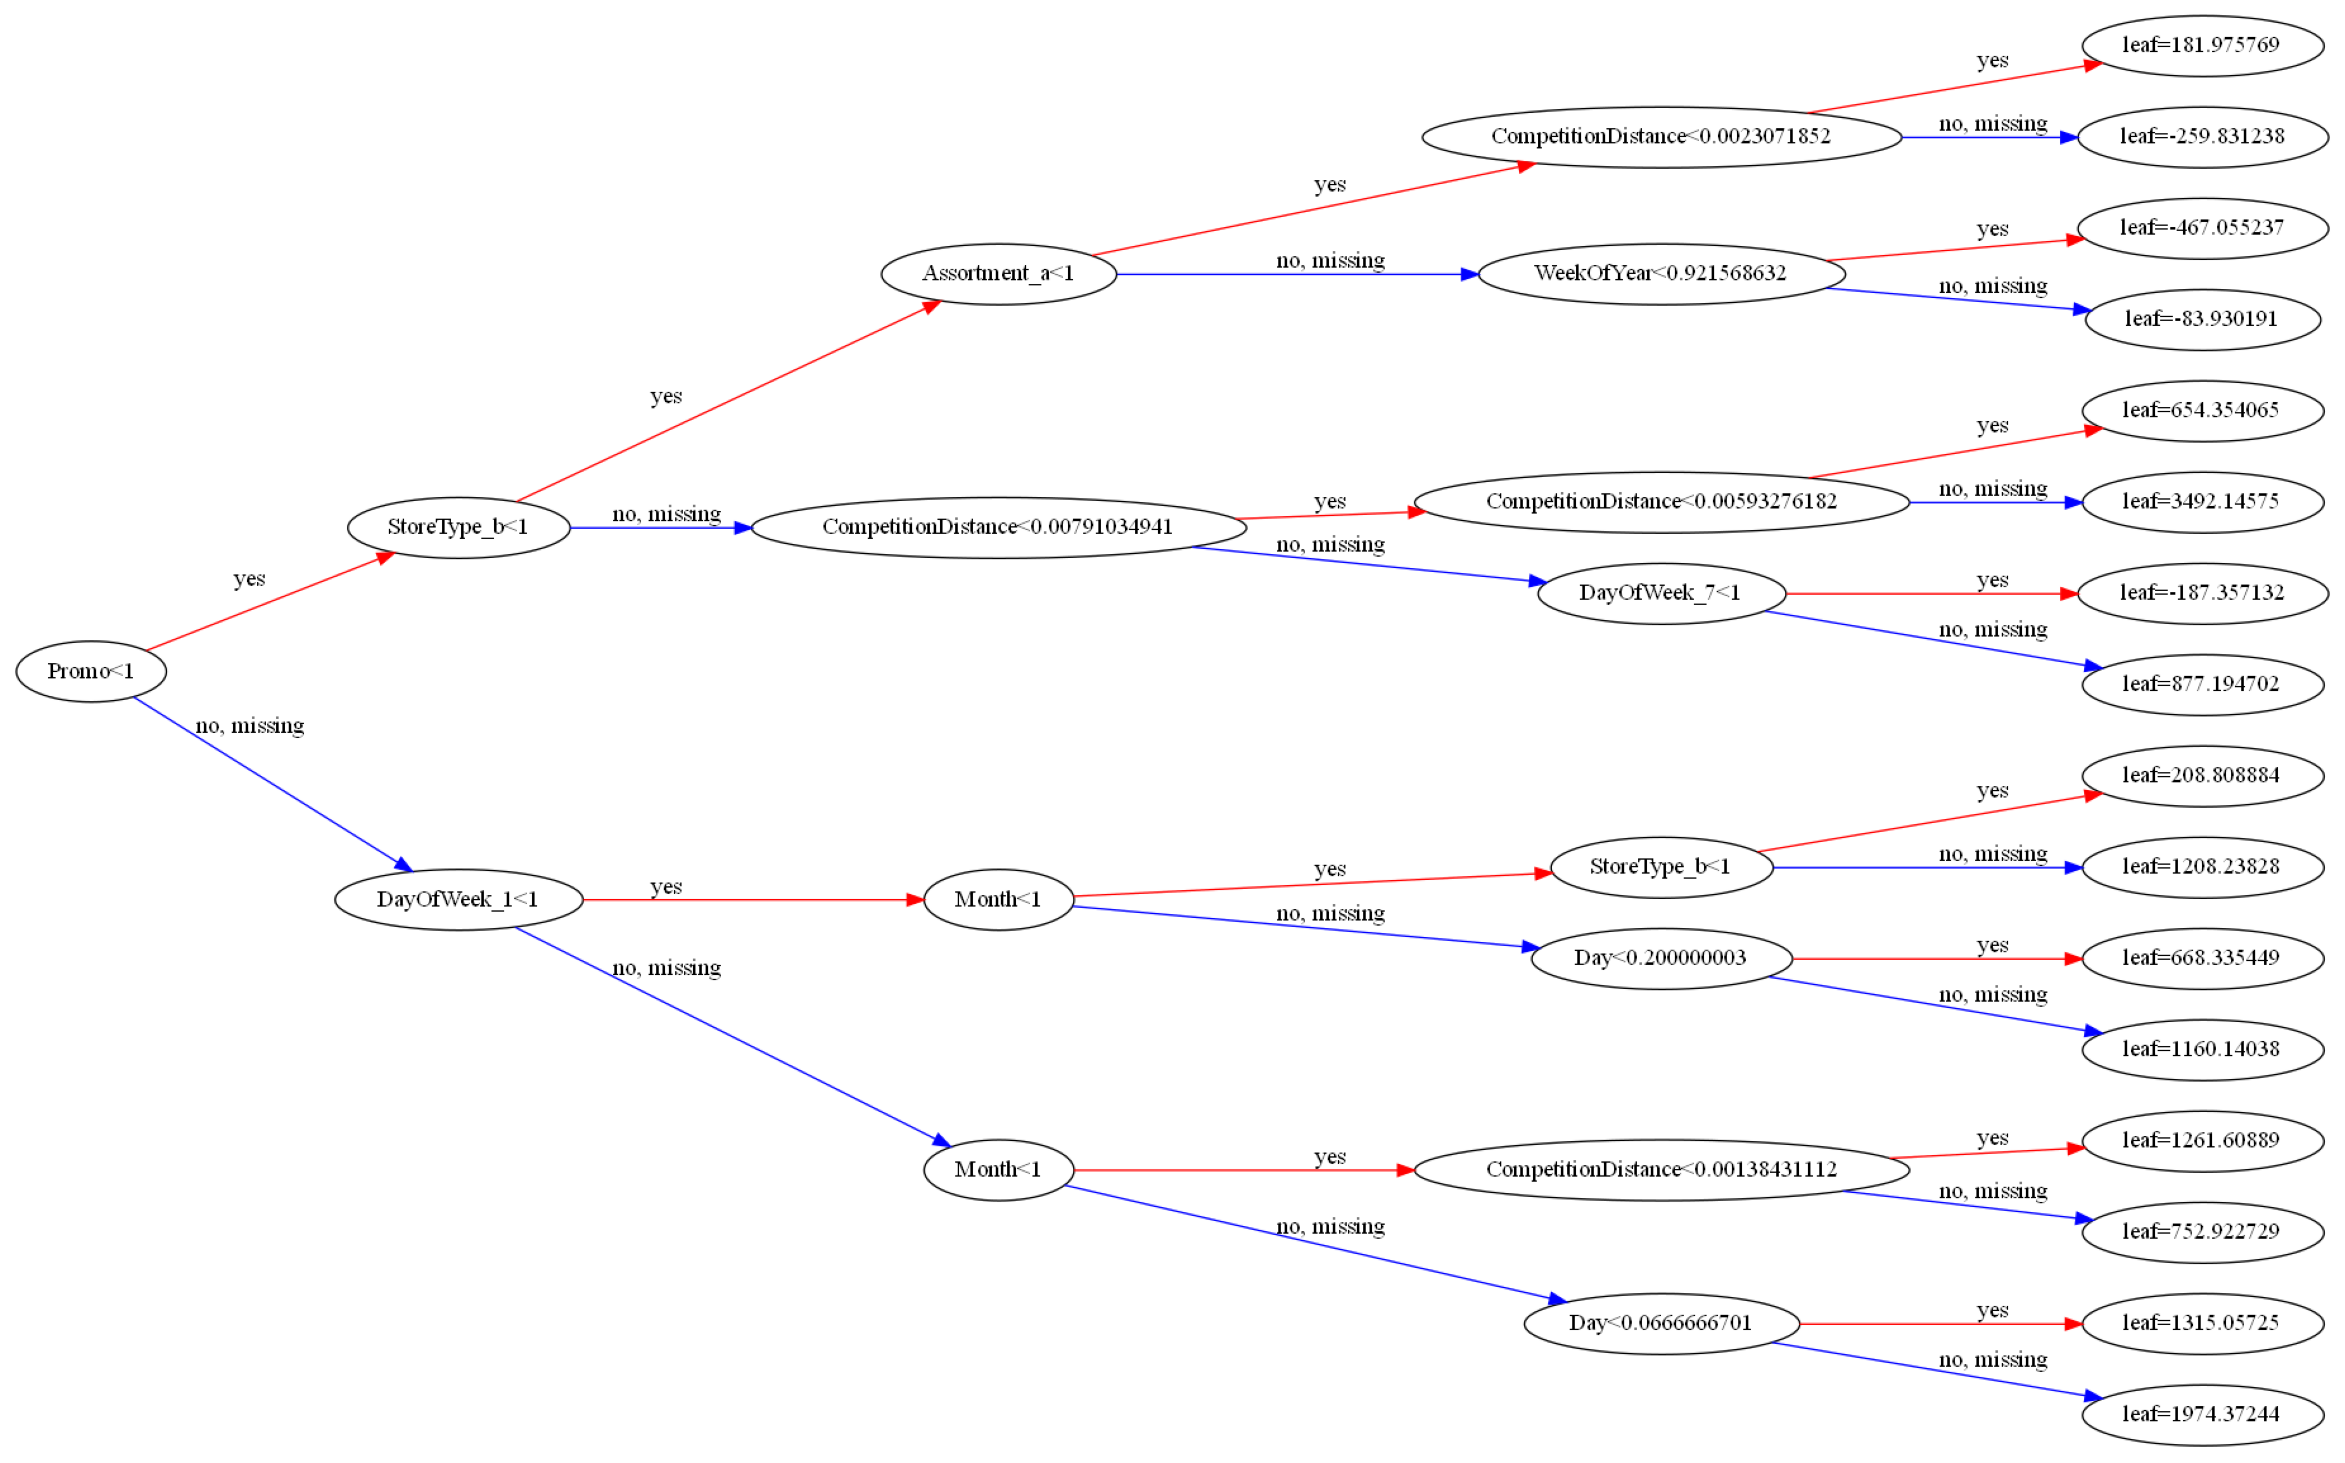

In [62]:
plot_tree(model, rankdir="LR", num_trees=0)

<Axes: >

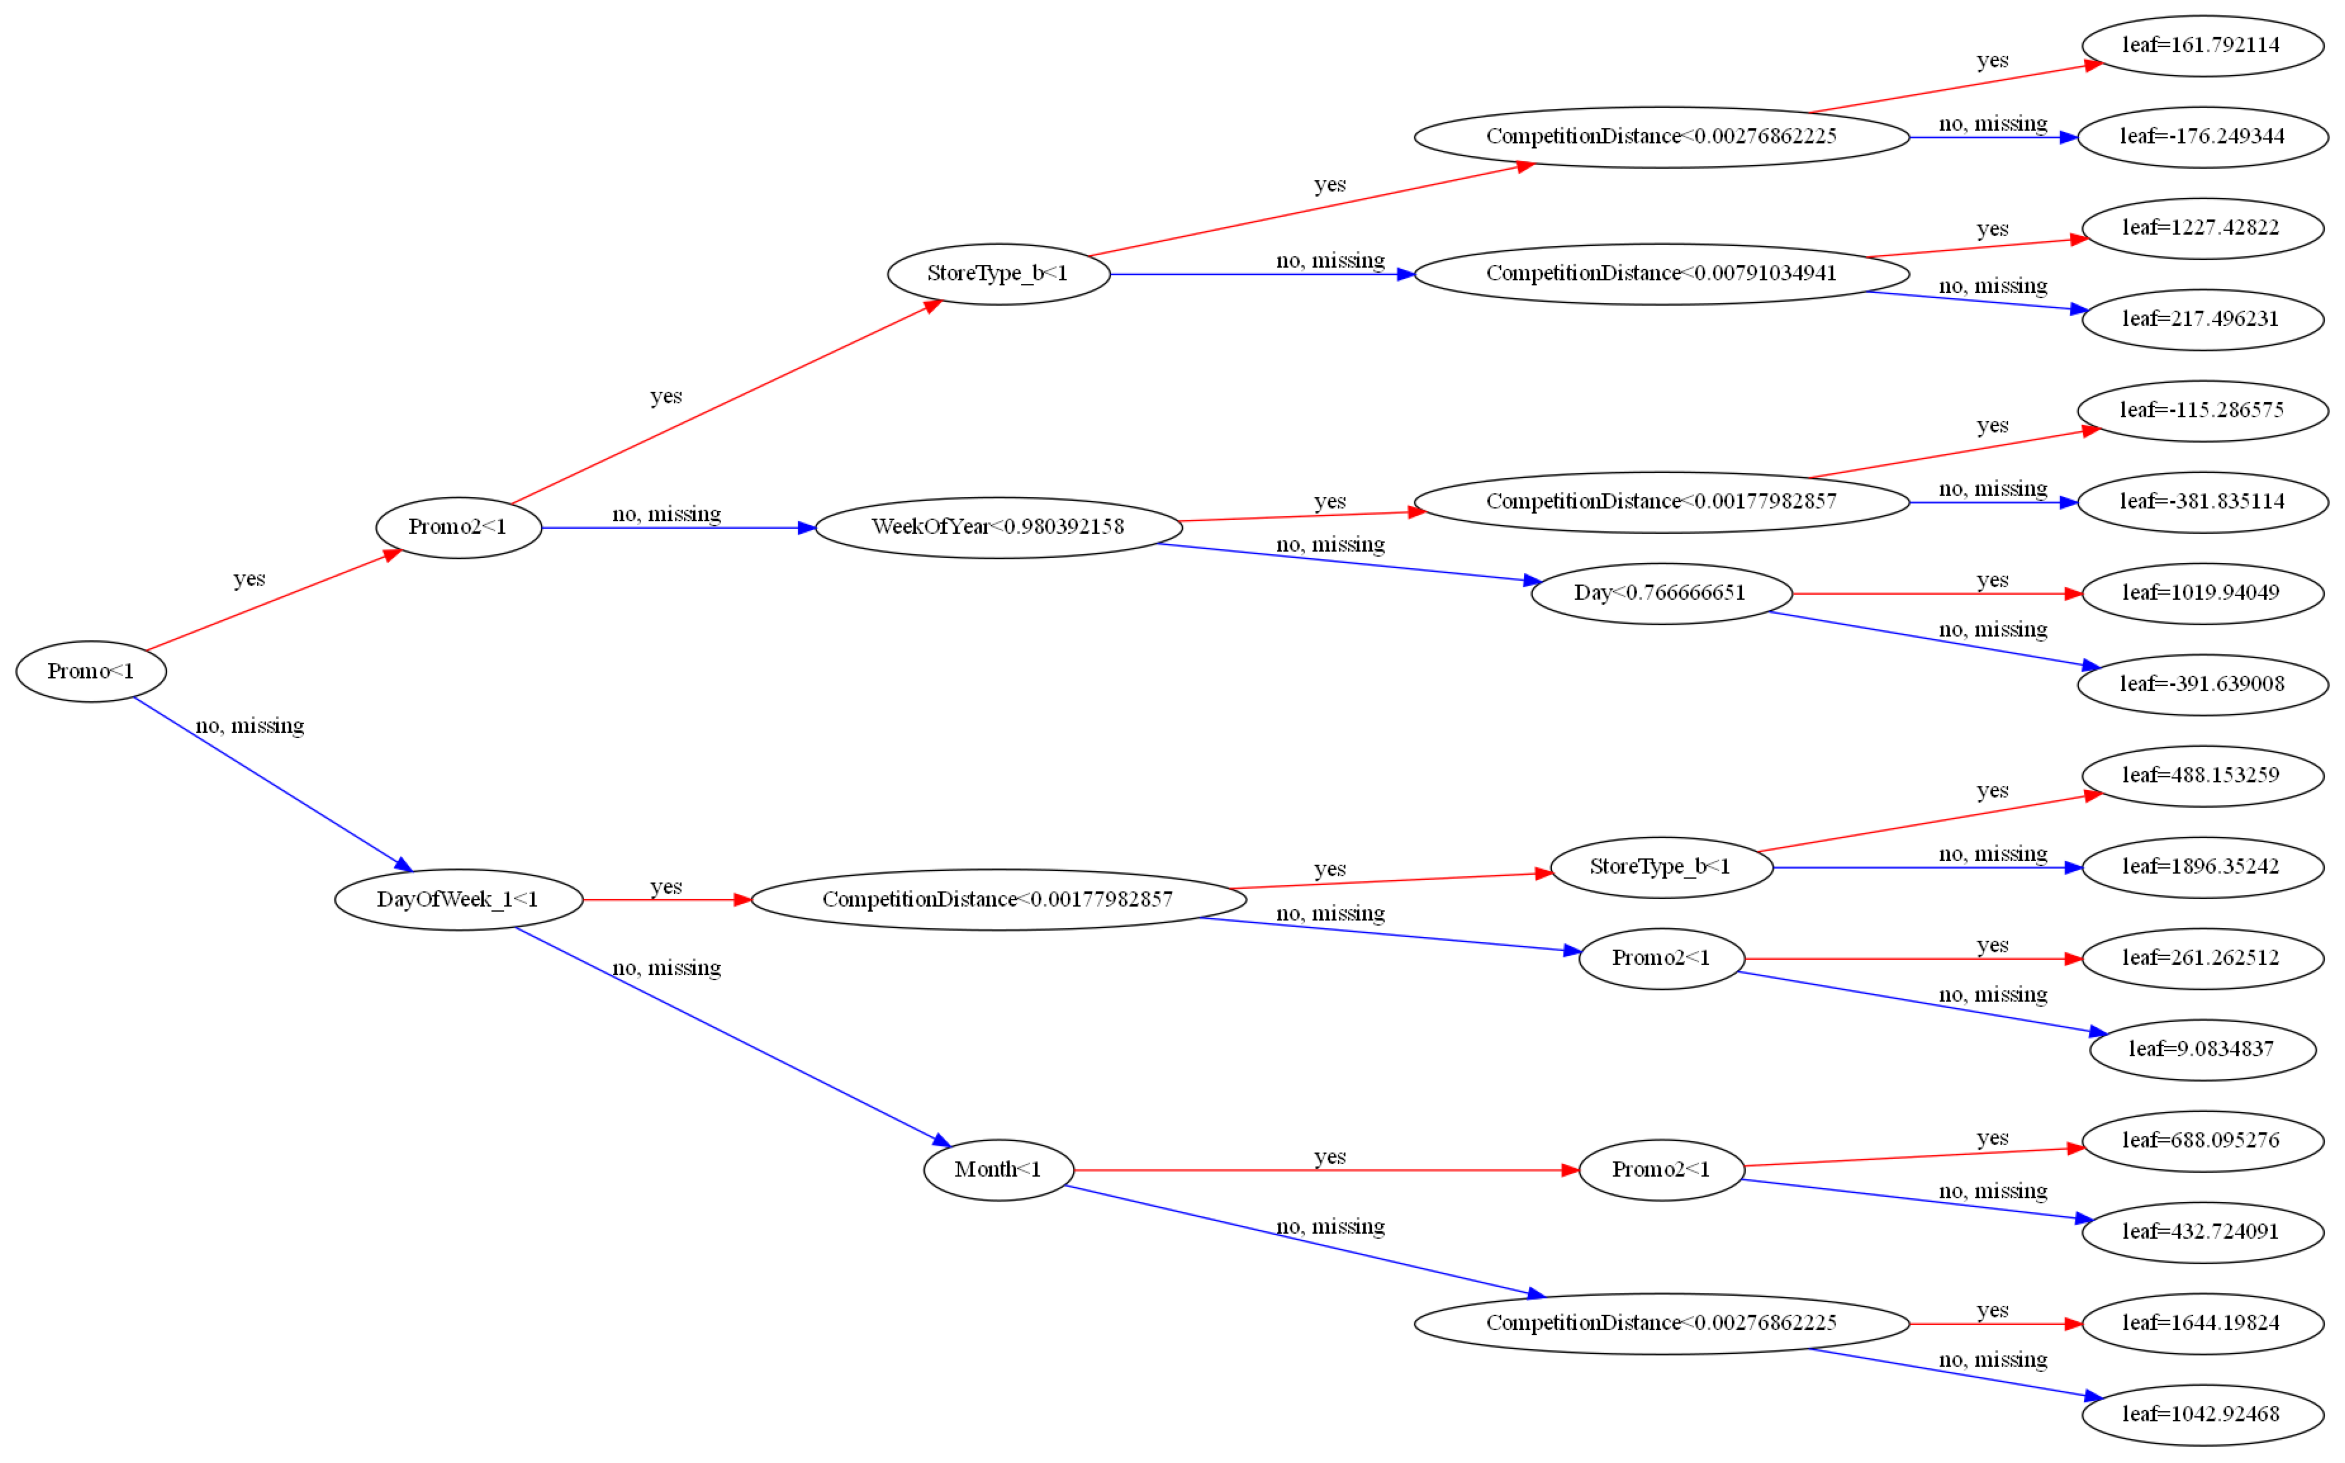

In [63]:
plot_tree(model, rankdir="LR", num_trees=1)

<Axes: >

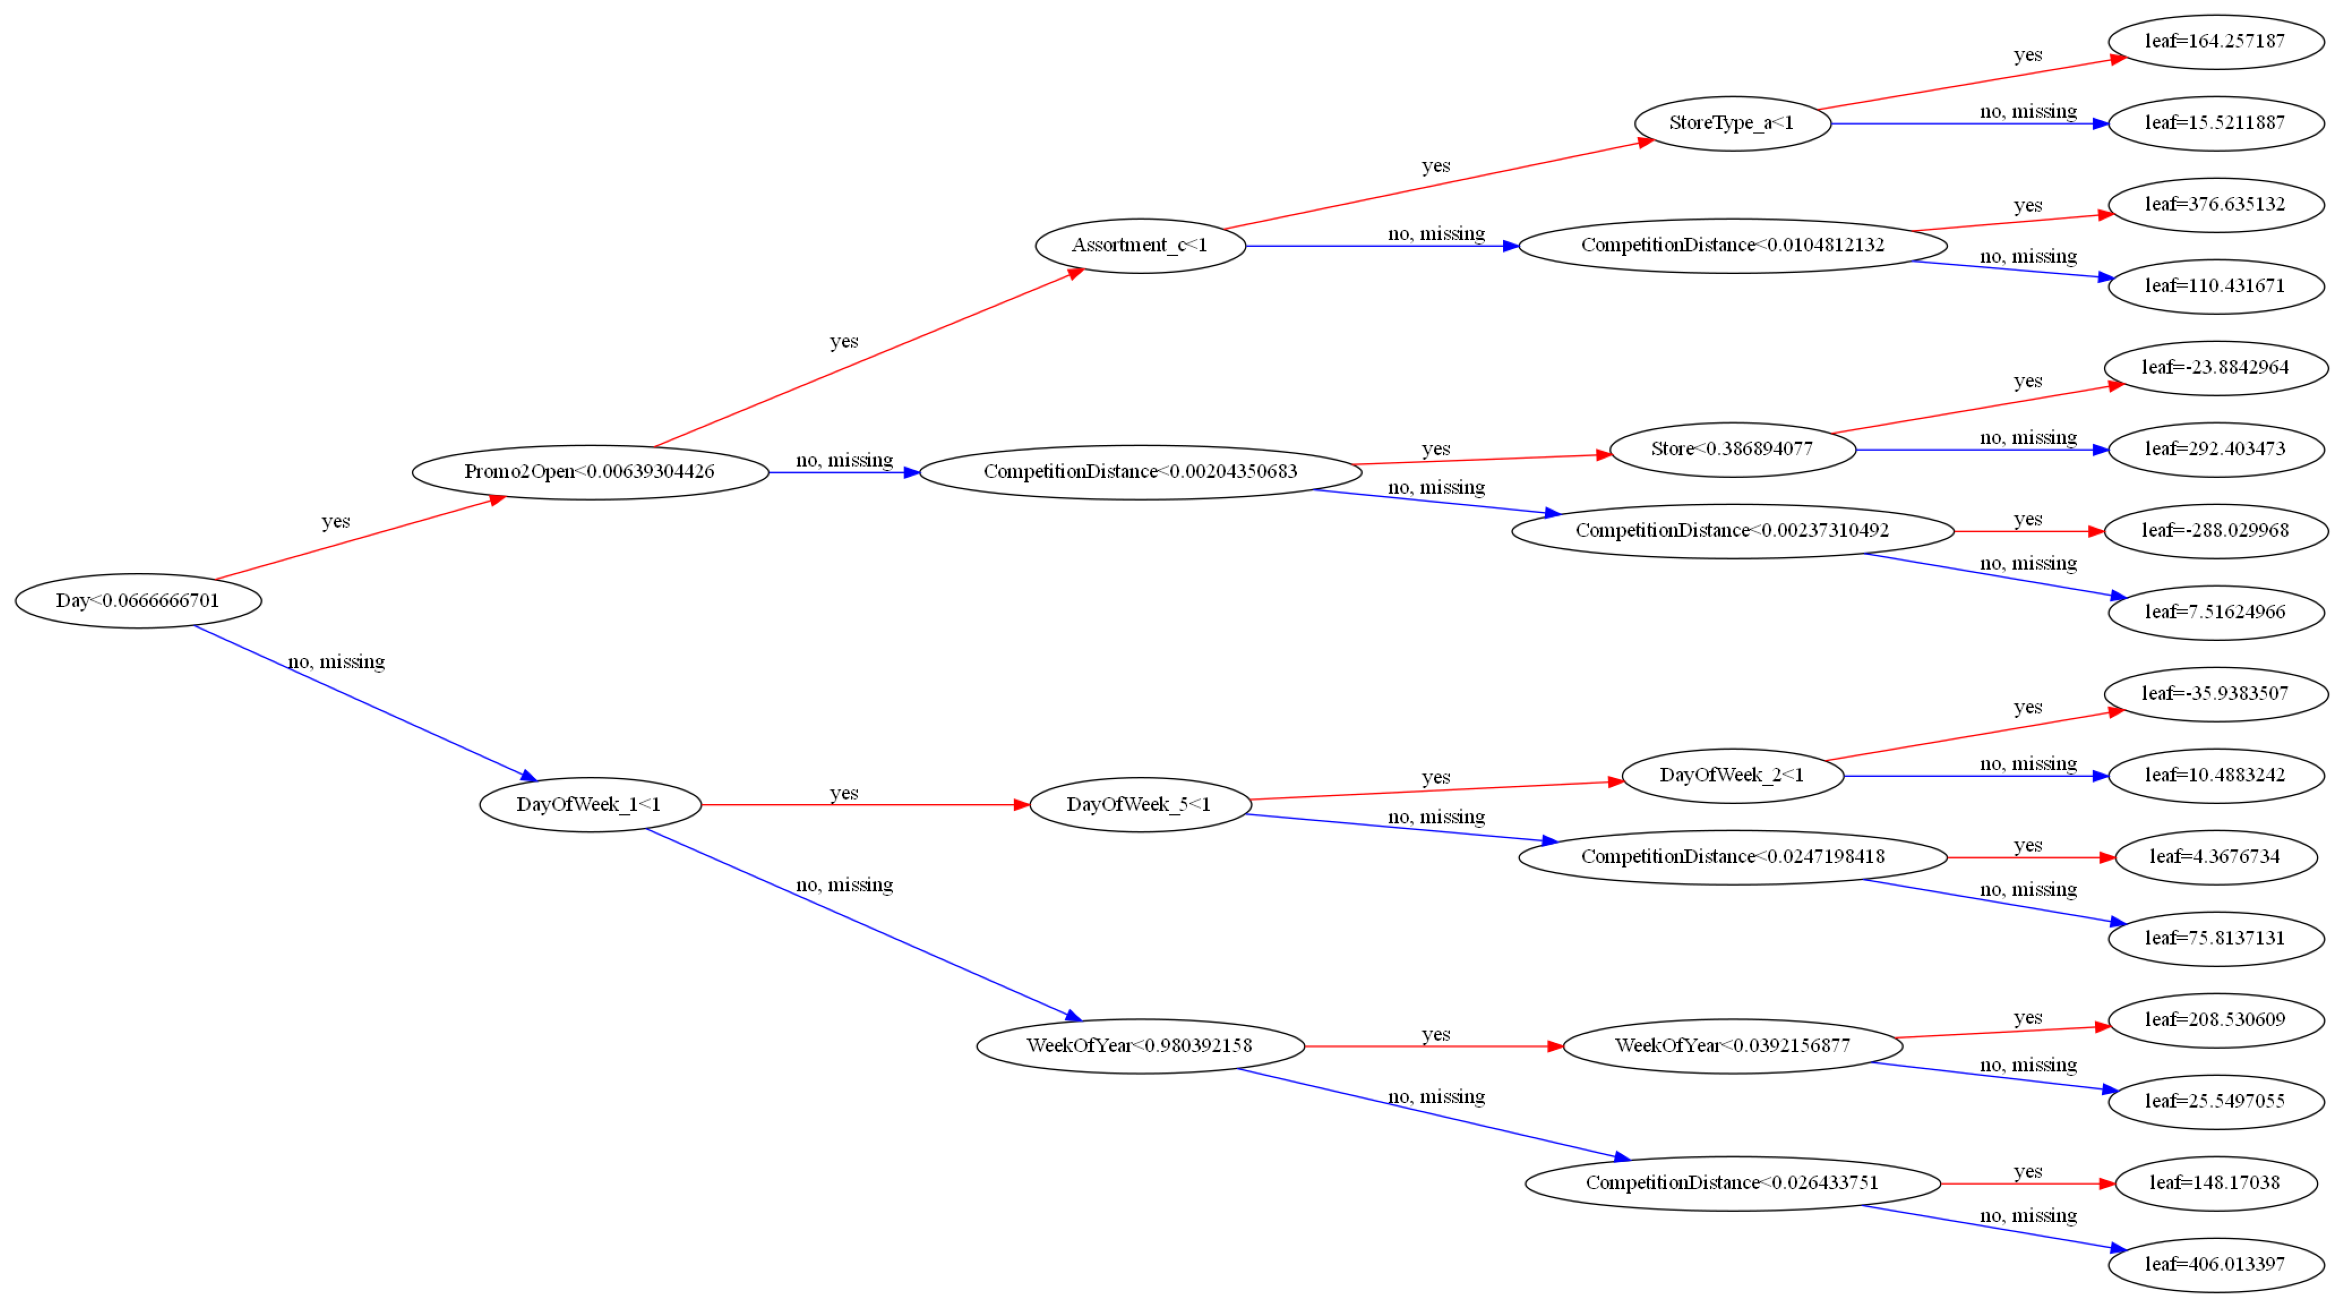

In [64]:
plot_tree(model, rankdir="LR", num_trees=19)

In [65]:
trees = model.get_booster().get_dump()
trees

['0:[Promo<1] yes=1,no=2,missing=2\n\t1:[StoreType_b<1] yes=3,no=4,missing=4\n\t\t3:[Assortment_a<1] yes=7,no=8,missing=8\n\t\t\t7:[CompetitionDistance<0.0023071852] yes=15,no=16,missing=16\n\t\t\t\t15:leaf=181.975769\n\t\t\t\t16:leaf=-259.831238\n\t\t\t8:[WeekOfYear<0.921568632] yes=17,no=18,missing=18\n\t\t\t\t17:leaf=-467.055237\n\t\t\t\t18:leaf=-83.930191\n\t\t4:[CompetitionDistance<0.00791034941] yes=9,no=10,missing=10\n\t\t\t9:[CompetitionDistance<0.00593276182] yes=19,no=20,missing=20\n\t\t\t\t19:leaf=654.354065\n\t\t\t\t20:leaf=3492.14575\n\t\t\t10:[DayOfWeek_7<1] yes=21,no=22,missing=22\n\t\t\t\t21:leaf=-187.357132\n\t\t\t\t22:leaf=877.194702\n\t2:[DayOfWeek_1<1] yes=5,no=6,missing=6\n\t\t5:[Month<1] yes=11,no=12,missing=12\n\t\t\t11:[StoreType_b<1] yes=23,no=24,missing=24\n\t\t\t\t23:leaf=208.808884\n\t\t\t\t24:leaf=1208.23828\n\t\t\t12:[Day<0.200000003] yes=25,no=26,missing=26\n\t\t\t\t25:leaf=668.335449\n\t\t\t\t26:leaf=1160.14038\n\t\t6:[Month<1] yes=13,no=14,missing=14\n\

In [66]:
# import os
# os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'

In [67]:
importances_df = pd.DataFrame({
    "feature": X_train.columns,
    "importances": model.feature_importances_
}).sort_values("importances", ascending=False)

<Axes: xlabel='importances', ylabel='feature'>

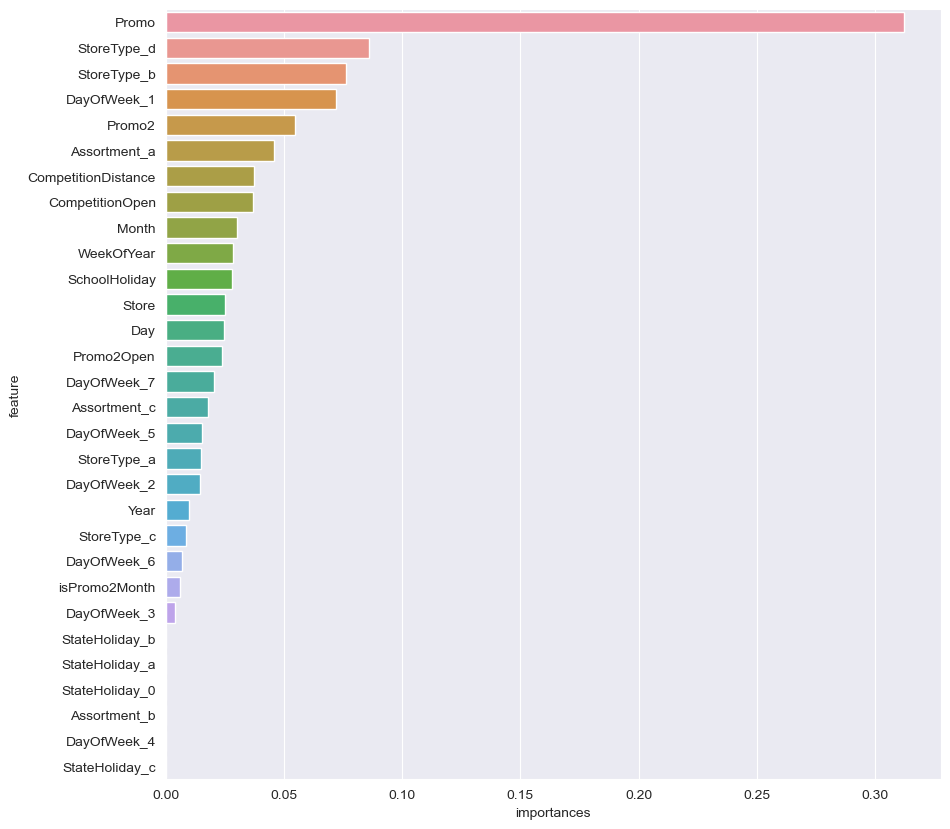

In [68]:
plt.rcParams['figure.figsize'] = (10, 10)
sns.barplot(data=importances_df, y="feature", x="importances")

In [69]:
print(trees[0])

0:[Promo<1] yes=1,no=2,missing=2
	1:[StoreType_b<1] yes=3,no=4,missing=4
		3:[Assortment_a<1] yes=7,no=8,missing=8
			7:[CompetitionDistance<0.0023071852] yes=15,no=16,missing=16
				15:leaf=181.975769
				16:leaf=-259.831238
			8:[WeekOfYear<0.921568632] yes=17,no=18,missing=18
				17:leaf=-467.055237
				18:leaf=-83.930191
		4:[CompetitionDistance<0.00791034941] yes=9,no=10,missing=10
			9:[CompetitionDistance<0.00593276182] yes=19,no=20,missing=20
				19:leaf=654.354065
				20:leaf=3492.14575
			10:[DayOfWeek_7<1] yes=21,no=22,missing=22
				21:leaf=-187.357132
				22:leaf=877.194702
	2:[DayOfWeek_1<1] yes=5,no=6,missing=6
		5:[Month<1] yes=11,no=12,missing=12
			11:[StoreType_b<1] yes=23,no=24,missing=24
				23:leaf=208.808884
				24:leaf=1208.23828
			12:[Day<0.200000003] yes=25,no=26,missing=26
				25:leaf=668.335449
				26:leaf=1160.14038
		6:[Month<1] yes=13,no=14,missing=14
			13:[CompetitionDistance<0.00138431112] yes=27,no=28,missing=28
				27:leaf=1261.60889
				28:leaf=752

### K Fold Cross Validation

1. K Fold is useful for small datatset but not recommended for larger datasets
2. K fold may not be the optimal strategy because our validation set should ideally reflect what kind of data the model is seeing in real life
3. So by using it now, we are breaking the requirement

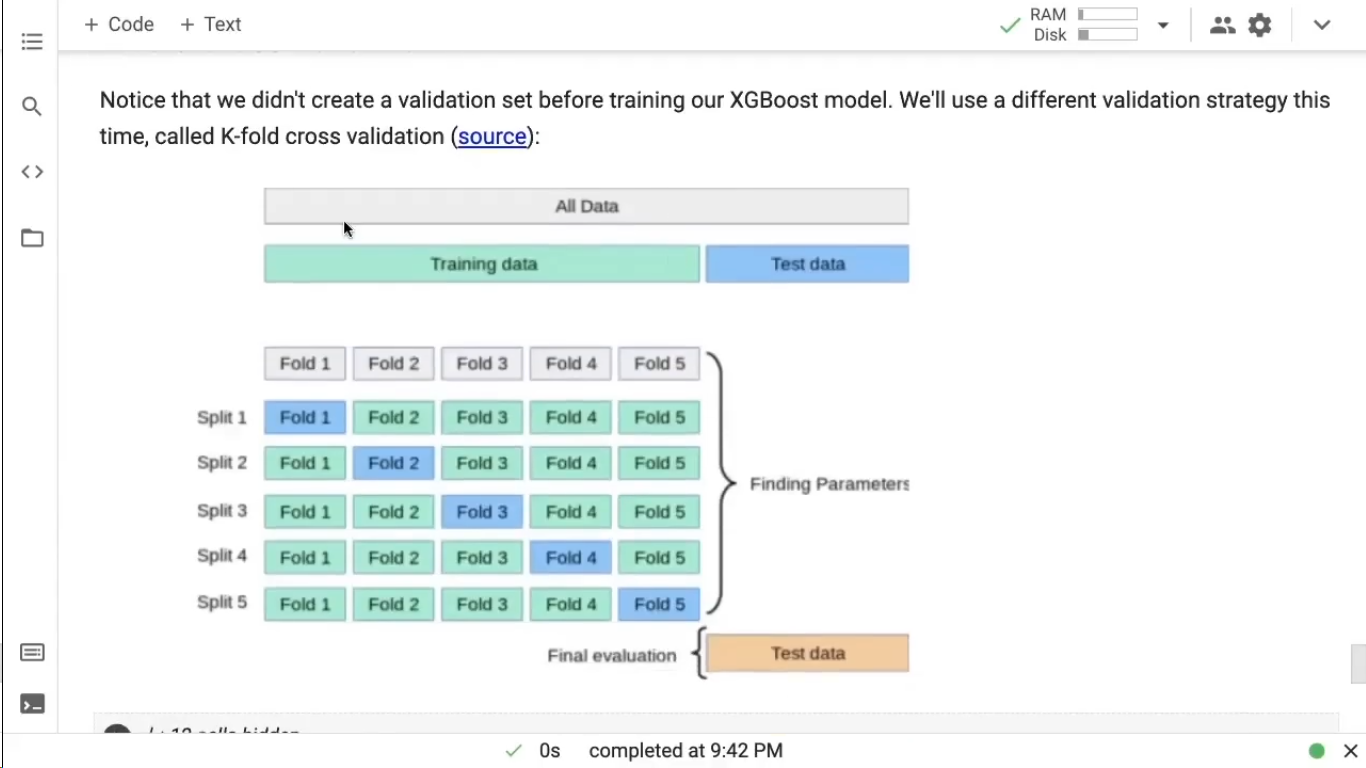

In [70]:
from sklearn.model_selection import KFold

In [71]:
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(n_jobs=-1, random_state=42, **params)
    model.fit(X_train, train_targets)
    train_rmse = mse(train_targets, model.predict(X_train), squared=False)
    val_rmse = mse(val_targets, model.predict(X_val), squared=False)
    
    return model, train_rmse, val_rmse

In [72]:
kfold = KFold(n_splits=5)

In [73]:
models = []
X = X_train.copy()
for train_idxs, val_idxs in kfold.split(X_train):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_rmse, val_rmse = train_and_evaluate(X_train, train_targets, X_val, val_targets, n_estimators=100, max_depth=4)

    models.append(model)
    print(f"Train RMSE: {train_rmse}, Validation RMSE: {val_rmse}")

Train RMSE: 1730.3215767168085, Validation RMSE: 1890.535729936027
Train RMSE: 1745.7967201860367, Validation RMSE: 1794.8062166739512
Train RMSE: 1732.4639157081765, Validation RMSE: 1767.8107228981155
Train RMSE: 1724.0893085004247, Validation RMSE: 1866.252229050483
Train RMSE: 1757.9127968257674, Validation RMSE: 1926.6467250110204


In [74]:
def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [75]:
(models[0].predict(X) + models[1].predict(X)) /2

array([7190.1914, 6895.77  , 9819.32  , ..., 8482.65  , 6497.6035,
       8401.892 ], dtype=float32)

## Hyper parameter Tuning and Regularization

In [ ]:
def test_params_kfold(n_splits,**params):
    train_rmses, val_rmses, models = [], [], []
    kfold = KFold(n_splits)
    for train_idxs, val_idxs in kfold.split(X):
        X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
        X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
        
        model, train_rmse, val_rmse = train_and_evaluate(X_train, train_targets, X_val, val_targets, **params)
 
        models.append(model)
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
        models.append(model)
        print(f"Train RMSE: {np.mean(train_rmse)}, Validation RMSE: {np.mean(val_rmse)}")        
        return train_rmses, val_rmses, models

In [ ]:
results = test_params_kfold(5, n_estimators=20, max_depth=3)

In [ ]:
results

In [76]:
from sklearn.model_selection import train_test_split

In [77]:
X_train, X_val, train_targets, val_targets = train_test_split(X, targets, test_size=0.1)

In [81]:
def test_params(**params):
    model = XGBRegressor(n_jobs=-1, random_state=42, **params)
    model.fit(X_train, train_targets)
    train_rmse = mse(train_targets, model.predict(X_train), squared=False)
    val_rmse = mse(val_targets, model.predict(X_val), squared=False)
    print(f"Train RMSE: {train_rmse}, Validation RMSE: {val_rmse}")

In [82]:
test_params(n_estimators=20)

Train RMSE: 2143.691621778794, Validation RMSE: 2131.7395704925616


In [83]:
test_params(n_estimators=40)

Train RMSE: 1721.5510562780173, Validation RMSE: 1720.8780591240657


In [84]:
test_params(n_estimators=240)

Train RMSE: 900.2450269635873, Validation RMSE: 911.9681340718497


In [85]:
test_params(max_depth=2)

Train RMSE: 2388.9115784654455, Validation RMSE: 2377.3861330146938


In [86]:
test_params(max_depth=2, n_estimators=10)

Train RMSE: 2690.5289497217805, Validation RMSE: 2669.128912382778


In [88]:
test_params(max_depth=10, n_estimators=240)

Train RMSE: 524.8323493250758, Validation RMSE: 688.7535034818219


In [89]:
test_params()

Train RMSE: 1176.6762268855207, Validation RMSE: 1180.446396162227


### Learning_rate
The scaling factor to be applied to the prediction of each tree (i.e. the alpha). A very high learning rate (close to 1) will lead to overfitting, and a low learning rate (close to 0) will lead to underfitting

In [90]:
test_params(n_estimators = 50, learning_rate = 0.01)

Train RMSE: 2790.7780998479384, Validation RMSE: 2771.7566415809897


In [92]:
test_params(n_estimators = 50, learning_rate=0.99)

Train RMSE: 1176.3217413909422, Validation RMSE: 1182.7492611272323


In [94]:
test_params(n_estimators = 50, learning_rate=0.79)

Train RMSE: 1118.4184635528632, Validation RMSE: 1123.3656862704565


In [96]:
test_params(n_estimators = 240, learning_rate=0.79, max_depth=10)

Train RMSE: 440.74957347396327, Validation RMSE: 777.1960349065151


### Booster
Instead of using decision trees, xgboost can also train a linear model for each iteration.

In [100]:
test_params(booster="gblinear", learning_rate=0.79, n_estimators=240)

Train RMSE: 2730.125122578799, Validation RMSE: 2705.174171911236


### Exercise: 
Train a model with your best hyperparameters and evaluate its performance using 5-fold cross validation


Experiment with other hyperparameters like gamma, min_child_weight, max_depth_step, subsample, colsample_bytree e.t.c

In [101]:
model = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=1000, learning_rate=0.79, max_depth=10, 
                     subsample=0.9, colsample_bytree=0.7)

In [102]:
model.fit(X, targets)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.79, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [117]:
test_preds = model.predict(X_test)

In [118]:
test_df.shape, test_preds.shape

((41088, 8), (41088,))

In [122]:
submission_df["Sales"] = test_preds

In [123]:
submission_df["Sales"]

0         5325.372559
1         7958.276855
2        13809.778320
3        10262.517578
4         8858.771484
             ...     
41083     2641.448486
41084     8393.384766
41085     5344.108887
41086    21492.003906
41087     6837.300293
Name: Sales, Length: 41088, dtype: float32

In [125]:
test_df.Open.isna().sum()

11

In [129]:
test_df.Open.value_counts()

1.0    35093
0.0     5984
Name: Open, dtype: int64

In [130]:
submission_df["Sales"] = submission_df["Sales"] * test_df.Open.fillna(1)

In [134]:
submission_df.sample(30)

,Id,Sales
12192,12193,8835.014648
1876,1877,12101.289062
13676,13677,9466.472656
14820,14821,7020.480957
29977,29978,7056.434570
37290,37291,7055.076172
32738,32739,6848.027344
30847,30848,9102.749023
29634,29635,8024.872070
575,576,12120.501953


In [136]:
test_df[test_df.Id == 28248]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
28247,28248,1115,7,2015-08-16,0.0,0,0,1
